# SPAM CLASSIFICATION USING CNN

1) INSTALLING AND IMPORTING REQUISITE CONFIGURATIONS

In [ ]:
pip install nlpaug

     |████████████████████████████████| 410 kB 4.1 MB/s 


In [ ]:
pip install transformers

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 45.5 MB/s 
     |████████████████████████████████| 6.8 MB 32.1 MB/s 
     |████████████████████████████████| 895 kB 48.4 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-02-20 12:38:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-20 12:38:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-20 12:38:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2022-02-20 12:41:06--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.25.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.25.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.1MB/s    in 1m 40s  

2022-02-20 12:42:48 (15.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
import pandas as pd
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import array
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,Embedding
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report
import os
import re
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nltk
from tqdm import tqdm
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


2) READING DATASET AND CLEANING TEXT

In [ ]:
import pandas as pd
df=pd.read_csv("Final_Combined_HaM_Spam.csv")
df1=pd.read_csv("Final_Combined_HaM_Spam.csv")

In [ ]:
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
pattern2= r'[0-9]+'
df['url']= df["Message"].str.extract(pattern, expand=False).str.strip()
df["Message"]= df["Message"].str.replace(pattern," ")
df["Message"]= df["Message"].str.replace(pattern2," ")
df["Message"]= df["Message"].str.replace("+","")
df['url'].fillna("-",inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [ ]:
df

,Unnamed: 0,Message,Lable,url
0,0,Important CoWIN update Vi Customer! The CoWin ...,0,https://bit.ly/Vi-Cowin
1,1,"Go until jurong point, crazy.. Available only ...",0,-
2,2,Ok lar... Joking wif u oni...,0,-
3,3,U dun say so early hor... U c already then say...,0,-
4,4,"Nah I don't think he goes to usf, he lives aro...",0,-
...,...,...,...,...
8746,8746,"Hi, Bill payment of Rs. has been initiated t...",0,-
8747,8747,"Hi, Bill payment of Rs. . has been initiated...",0,-
8748,8748,"Hi, Bill payment of Rs. . has been initiated...",0,-
8749,8749,"Hi, Bill payment of Rs. has been initiated t...",0,-


In [ ]:
messg=list(df["Message"])
lable=list(df["Lable"])
df['Lable'].value_counts()

0    5669
1    3082
Name: Lable, dtype: int64

In [ ]:
messg=[str(x) for x in messg]

In [ ]:
train_msg, test_msg, Y_train, Y_test =train_test_split(messg,lable,test_size=0.1)

3) PERFORMING DATA AUGMENTATION


*   Character Replacement
*   Word Replacement with synonyms



In [ ]:
aug1 = nac.KeyboardAug(aug_char_p=0.05,aug_char_max=4)
aug2 = naw.SynonymAug(aug_p=0.4,aug_max=15)

In [ ]:
def augment(messages, cate):
  spam_augmented_data=[]
  ham_augmented_data=[]

  for msg,cat in zip(tqdm(messages),cate):
    #s1=aug1.augment(msg)
    #spam_augmented_data.extend([msg])
    for i in range(2):
       s2=aug2.augment(msg)
       if cat==1:
        spam_augmented_data.append(s2)
       else:
        ham_augmented_data.append(s2)
  return spam_augmented_data,ham_augmented_data

s,h=augment(train_msg, Y_train)
sl=[1]*len(s)
hl=[0]*len(h)
train_msg=s+h
Y_train=sl+hl

100%|██████████| 8749/8749 [00:38<00:00, 230.04it/s]


4) WORD TOKENIZATION AND LEMMATIZATION

In [ ]:
def clean_data(messages):
  clean_docs=[]
  for doc in tqdm(nlp.pipe(messages)):
      s=" ".join([token.lemma_ for token in doc if not (token.is_stop or token.is_punct)])
      clean_docs.append(s)
  return clean_docs

processed_messages=clean_data(train_msg)
train_msg=[s.replace('r ',"Rs") for s in processed_messages] 

17498it [00:52, 333.25it/s]


In [ ]:
import pickle

# # saving
#  with open('drive/MyDrive/Spam_Models/tokenizer_M3P_31_01.pickle', 'wb') as handle:
#      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('drive/MyDrive/Spam_Models/tokenizer_M3P_fullData.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# # loading
# with open('tokenizer_97_24.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [ ]:
# train=pd.DataFrame({
#     "Message":train_msg,
#     "Label":Y_train
# })

# test=pd.DataFrame({
#     "Message":test_msg,
#     "Label":Y_test
# })
# train.to_csv('train_new_banking.csv')
# test.to_csv('test_new_banking.csv')

In [ ]:
# train=pd.read_csv("train_new_banking.csv")
# test=pd.read_csv("test_new_banking.csv")
# train.Message=train.Message.astype(str)
# test.Message=test.Message.astype(str)
# train_msg, test_msg=list(train['Message']),list(test['Message'])
# Y_train, Y_test=list(train['Label']),list(test['Label'])

In [ ]:
def create_tokenizer(messages):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(messages)
	return tokenizer

def max_length(messages):
	return max([len(s.split()) for s in messages])
 
def encode_text(tokenizer, messages, length):
	#print(len(messages))
	encoded = tokenizer.texts_to_sequences(messages)
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	print(padded)
	return padded

tokenizer= create_tokenizer(train_msg)
# with open('drive/MyDrive/Spam_Models/tokenizer_latest_banking.pickle', 'rb') as handle:
#       tokenizer = pickle.load(handle)
length=max_length(train_msg)
vocab_size = len(tokenizer.word_index) + 1

X_train= encode_text(tokenizer, train_msg, length)
X_test= encode_text(tokenizer, test_msg, length)
print(X_train.shape)

[[   2  241 5878 ...    0    0    0]
 [  38   12   11 ...    0    0    0]
 [ 736 4613  229 ...    0    0    0]
 ...
 [ 163   80  445 ...    0    0    0]
 [  89   26  404 ...    0    0    0]
 [  89  113   26 ...    0    0    0]]
[[  358 12019   184  1416  1701     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [  358   223  3021 11682   353   568    51   184  1017   158    41     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0    

In [ ]:
t=['Buy 1/2/3 BHK @North Garden City,Mira RdClose to New Metro Stn.FREE pickup & drop, for Site Visit Amenity Club Library Swimming pool, kids pool & Ladies Pool Meeting room Table tennis & indoor game room Steam, Sauna & Spa Gymnasium Guest rooms Mini theatre (Screening) Banquet Hall & multipurpose deckBox Cricket Court with spectator seating Jogging track Senior citizen GardenYoga/Meditation Garden http://ds3.in/s.s?N0YN6W02']
print("Original             ",t[0])
t[0]=re.sub(pattern2,"",t[0])
t[0]=re.sub(pattern,"",t[0])
s1=aug1.augment(t)
s2=aug2.augment(t)

print("After Replacement    ",t[0])
print("After Character Augmentation 1 ",s1[0])
print("After Word Augmentation 2 ",s2[0])

c1=clean_data([t[0],s1[0],s2[0]])
print()
for i,c in enumerate(c1):
  print(f"After Tokenisation of sentence {i+1} ",c)
print(encode_text(tokenizer, c1, length))

Original              Buy 1/2/3 BHK @North Garden City,Mira RdClose to New Metro Stn.FREE pickup & drop, for Site Visit Amenity Club Library Swimming pool, kids pool & Ladies Pool Meeting room Table tennis & indoor game room Steam, Sauna & Spa Gymnasium Guest rooms Mini theatre (Screening) Banquet Hall & multipurpose deckBox Cricket Court with spectator seating Jogging track Senior citizen GardenYoga/Meditation Garden http://ds3.in/s.s?N0YN6W02
After Replacement     Buy // BHK @North Garden City,Mira RdClose to New Metro Stn.FREE pickup & drop, for Site Visit Amenity Club Library Swimming pool, kids pool & Ladies Pool Meeting room Table tennis & indoor game room Steam, Sauna & Spa Gymnasium Guest rooms Mini theatre (Screening) Banquet Hall & multipurpose deckBox Cricket Court with spectator seating Jogging track Senior citizen GardenYoga/Meditation Garden 
After Character Augmentation 1  Buy / / BHK @ North Garden City, Mira $dClose to New Metro Stn. FREE pickup & drop, for Sute Visi4 

3it [00:00, 60.51it/s]


After Tokenisation of sentence 1  buy BHK @North Garden City Mira RdClose New Metro Stn FREE pickup drop Site Visit Amenity Club Library Swimming pool kid pool Ladies Pool Meeting room table tennis indoor game room Steam Sauna Spa Gymnasium Guest room mini theatre Screening Banquet Hall multipurpose deckBox Cricket Court spectator seat Jogging track senior citizen GardenYoga Meditation Garden
After Tokenisation of sentence 2  buy BHK North Garden City Mira $ dclose New Metro Stn FREE pickup drop Sute Visi4 Amenity Club Library Swimming pool Mids pool Ladies Pool mee4e rooN table tennis indoor game room Steam Sauna Spa Gymnasium Guest roons mini theatre Screening Banquet Hall multipurpose deckBox Cricket Court spectator seat Joggimg track senior citiz$n GardenYiga Meditation Garden
After Tokenisation of sentence 3  buy BHK North Garden Urban center Mira RdClose New Subway Stn FREE pickup drop Site Sojourn Amenity Society Program library Swimming pool kid pool Ladies Pool Meeting elbow 

5) INITIALIZING THE EMBEDDING MATRIX

In [ ]:
num_tokens = vocab_size
embedding_dim = 300

# Prepare embedding matrix
w2v_embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_docs.items():
  w2v_embedding_matrix[i]=word2vec[word] if word in word2vec else np.random.rand(embedding_dim)

In [ ]:
path_to_glove_file = os.path.join("glove.6B.100d.txt")
num_tokens = vocab_size
embedding_dim = 100
hits = 0
misses = 0

g_embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        g_embeddings_index[word] = coefs
# Prepare embedding matrix
glove_embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_docs.items():
    embedding_vector = g_embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        glove_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11245 words (12155 misses)


In [ ]:
length

75

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import time
model1 = LogisticRegression()
start_time = time.time()
model1.fit(X_train, Y_train)
end_time = time.time()
print("Logistic Regression")
print("Training time: ",end_time-start_time)
t1=end_time-start_time
start_time = time.time()
Y_test_pred1 = model1.predict(X_test)
end_time = time.time()
_,_,f1,_=precision_recall_fscore_support(Y_test, Y_test_pred1, average='macro')
print("Testing time: ",end_time-start_time)
print(classification_report(Y_test, Y_test_pred1))
print("Average F1 Score ",f1)

model1 = GradientBoostingClassifier(n_estimators=50)
print("Gradient Boosting Classifier")
start_time = time.time()
model1.fit(X_train, Y_train)
end_time = time.time()
print("Training time: ",end_time-start_time)
t1=end_time-start_time
start_time = time.time()
Y_test_pred1 = model1.predict(X_test)
end_time = time.time()
_,_,f1,_=precision_recall_fscore_support(Y_test, Y_test_pred1, average='macro')
print("Testing time: ",end_time-start_time)
print(classification_report(Y_test, Y_test_pred1))
print("Average F1 Score ",f1)


model1 = DecisionTreeClassifier(max_depth=100)
print("Decision Trees")
start_time = time.time()
model1.fit(X_train, Y_train)
end_time = time.time()
print("Training time: ",end_time-start_time)
t1=end_time-start_time
start_time = time.time()
Y_test_pred1 = model1.predict(X_test)
end_time = time.time()
_,_,f1,_=precision_recall_fscore_support(Y_test, Y_test_pred1, average='macro')
print("Testing time: ",end_time-start_time)
print(classification_report(Y_test, Y_test_pred1))
print("Average F1 Score ",f1)

model1 = GaussianNB()
print("Naive Bayes")
start_time = time.time()
model1.fit(X_train, Y_train)
end_time = time.time()
print("Training time: ",end_time-start_time)
t1=end_time-start_time
start_time = time.time()
Y_test_pred1 = model1.predict(X_test)
end_time = time.time()
_,_,f1,_=precision_recall_fscore_support(Y_test, Y_test_pred1, average='macro')
print("Testing time: ",end_time-start_time)
print(classification_report(Y_test, Y_test_pred1))
print("Average F1 Score ",f1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression
Training time:  0.4595012664794922
Testing time:  0.00028014183044433594
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Average F1 Score  1.0
Gradient Boosting Classifier
Training time:  4.118262529373169
Testing time:  0.0007317066192626953
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Average F1 Score  1.0
Decision Trees
Training time:  0.4888646602630615
Testing time:  0.0009505748748779297
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
sorted(train_msg,key=lambda x:len(x),reverse=True)[0:10]

['hi Gopalkrishna Ratilal KYC CoinSwitch KubeRscomplete successfully try information technology contact customeRssupport case issue CoinSwitch KuberHi Gopalkrishna Ratilal KYC CoinSwitch KubeRscomplete successfully try contact customeRssupport case issue CoinSwitch KuberHi Gopalkrishna Ratilal KYC CoinSwitch KubeRscost complete successfully try information technology contact customeRssupport case issue CoinSwitch KuberHi Gopalkrishna Ratilal KYC CoinSwitch KubeRsnon complete successfully try hold customeRssupport caseful issue CoinSwitch KuberHi Gopalkrishna Ratilal KYC CoinSwitch KubeRscomplete successfully try adjoin customeRssupport case issue CoinSwitch Kuber',
 'hi Gopalkrishna Ratilal KYC CoinSwitch KubeRsexist complete successfully try information technology contact customeRsbacking case issue CoinSwitch KuberHi Gopalkrishna Ratilal KYC CoinSwitch KubeRsnon complete successfully attempt reach customeRssupport case event CoinSwitch KuberHi Gopalkrishna Ratilal KYC CoinSwitch Kube

6) MODEL DEFINITION AND TRAINING

In [ ]:
from keras import backend as K
K.clear_session()
#Parallel M3P
def define_model1(length, vocab_size):
    # channel 1

        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 100,
                                                    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
                                                    trainable=True,name='GloVe_Emb')(inputs1)
        conv1 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C1_Conv_1')(embedding1)
        conv11 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C1_Conv_2')(embedding1)
        conv111 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C1_Conv_3')(embedding1)
        conv1111 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C1_Conv_4')(embedding1)
        merg1= concatenate([conv1,conv11,conv111,conv1111]) 
        drop1 = Dropout(0.5)(merg1)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)
        
    
        # channel 2
        inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 100,name='Random_Emb')(inputs2)
        conv2 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C2_Conv_1')(embedding2)
        conv22 = Conv1D(filters=64, kernel_size=5, activation='relu',padding='same',name='C2_Conv_2')(embedding2)
        conv222 = Conv1D(filters=128, kernel_size=3, activation='relu',padding='same',name='C2_Conv_3')(embedding2)
        conv2222 = Conv1D(filters=128, kernel_size=2, activation='relu',padding='same',name='C2_Conv_4')(embedding2)
        merg2= concatenate([conv2,conv22,conv222,conv2222]) 
        drop2 = Dropout(0.5)(merg2)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)
        #channel 3
        inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300,
                                                    embeddings_initializer=keras.initializers.Constant(w2v_embedding_matrix),
                                                    trainable=True,name='Word2Vec_Emb')(inputs3)
        conv3 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C3_Conv_1')(embedding3)
        conv33 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C3_Conv_2')(embedding3)
        conv333 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C3_Conv_3')(embedding3)
        conv3333 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C3_Conv_4')(embedding3)
        merg3= concatenate([conv3,conv33,conv333,conv3333]) 
        drop3 = Dropout(0.5)(merg3)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)
        # #merge
        merged = concatenate([flat1,flat2,flat3])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs1,inputs2,inputs3], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Parallel M2P W+G
def define_model2(length, vocab_size):
    # channel 1

        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 100,
                                                    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
                                                    trainable=False,name='GloVe_Emb')(inputs1)
        conv1 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C1_Conv_1')(embedding1)
        conv11 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C1_Conv_2')(embedding1)
        conv111 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C1_Conv_3')(embedding1)
        conv1111 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C1_Conv_4')(embedding1)
        merg1= concatenate([conv1,conv11,conv111,conv1111]) 
        drop1 = Dropout(0.5)(merg1)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)

        #channel 3
        inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300,
                                                    embeddings_initializer=keras.initializers.Constant(w2v_embedding_matrix),
                                                    trainable=False,name='Word2Vec_Emb')(inputs3)
        conv3 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C3_Conv_1')(embedding3)
        conv33 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C3_Conv_2')(embedding3)
        conv333 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C3_Conv_3')(embedding3)
        conv3333 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C3_Conv_4')(embedding3)
        merg3= concatenate([conv3,conv33,conv333,conv3333]) 
        drop3 = Dropout(0.5)(merg3)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)
        # #merge
        merged = concatenate([flat1,flat3])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs1,inputs3], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Parallel M2S G+R
def define_model3(length, vocab_size):
    # channel 1

        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 100,
                                                    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
                                                    trainable=False,name='GloVe_Emb')(inputs1)
        conv1 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C1_Conv_1')(embedding1)
        conv11 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C1_Conv_2')(embedding1)
        conv111 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C1_Conv_3')(embedding1)
        conv1111 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C1_Conv_4')(embedding1)
        merg1= concatenate([conv1,conv11,conv111,conv1111]) 
        drop1 = Dropout(0.5)(merg1)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)
        
    
        # channel 2
        inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 100,name='Random_Emb')(inputs2)
        conv2 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C2_Conv_1')(embedding2)
        conv22 = Conv1D(filters=64, kernel_size=5, activation='relu',padding='same',name='C2_Conv_2')(embedding2)
        conv222 = Conv1D(filters=128, kernel_size=3, activation='relu',padding='same',name='C2_Conv_3')(embedding2)
        conv2222 = Conv1D(filters=128, kernel_size=2, activation='relu',padding='same',name='C2_Conv_4')(embedding2)
        merg2= concatenate([conv2,conv22,conv222,conv2222]) 
        drop2 = Dropout(0.5)(merg2)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)
        # #merge
        merged = concatenate([flat1,flat2])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs1,inputs2], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Parallel M2P R+W
def define_model4(length, vocab_size):
        # channel 2
        inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 100,name='Random_Emb')(inputs2)
        conv2 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C2_Conv_1')(embedding2)
        conv22 = Conv1D(filters=64, kernel_size=5, activation='relu',padding='same',name='C2_Conv_2')(embedding2)
        conv222 = Conv1D(filters=128, kernel_size=3, activation='relu',padding='same',name='C2_Conv_3')(embedding2)
        conv2222 = Conv1D(filters=128, kernel_size=2, activation='relu',padding='same',name='C2_Conv_4')(embedding2)
        merg2= concatenate([conv2,conv22,conv222,conv2222]) 
        drop2 = Dropout(0.5)(merg2)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)
        #channel 3
        inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300,
                                                    embeddings_initializer=keras.initializers.Constant(w2v_embedding_matrix),
                                                    trainable=False,name='Word2Vec_Emb')(inputs3)
        conv3 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C3_Conv_1')(embedding3)
        conv33 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C3_Conv_2')(embedding3)
        conv333 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C3_Conv_3')(embedding3)
        conv3333 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C3_Conv_4')(embedding3)
        merg3= concatenate([conv3,conv33,conv333,conv3333]) 
        drop3 = Dropout(0.5)(merg3)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)
        # #merge
        merged = concatenate([flat2,flat3])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs2,inputs3], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Parallel M1P G
def define_model5(length, vocab_size):
    # channel 1

        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 100,
                                                    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
                                                    trainable=False,name='GloVe_Emb')(inputs1)
        conv1 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C1_Conv_1')(embedding1)
        conv11 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C1_Conv_2')(embedding1)
        conv111 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C1_Conv_3')(embedding1)
        conv1111 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C1_Conv_4')(embedding1)
        merg1= concatenate([conv1,conv11,conv111,conv1111]) 
        drop1 = Dropout(0.5)(merg1)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)
        # #merge
        merged = concatenate([flat1])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs1], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model
#Parallel M1P R
def define_model6(length, vocab_size):
    # channel 1

        # channel 2
        inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 100,name='Random_Emb')(inputs2)
        conv2 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C2_Conv_1')(embedding2)
        conv22 = Conv1D(filters=64, kernel_size=5, activation='relu',padding='same',name='C2_Conv_2')(embedding2)
        conv222 = Conv1D(filters=128, kernel_size=3, activation='relu',padding='same',name='C2_Conv_3')(embedding2)
        conv2222 = Conv1D(filters=128, kernel_size=2, activation='relu',padding='same',name='C2_Conv_4')(embedding2)
        merg2= concatenate([conv2,conv22,conv222,conv2222]) 
        drop2 = Dropout(0.5)(merg2)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)
        # #merge
        merged = concatenate([flat2])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs2], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model
#Parallel M1P W
def define_model7(length, vocab_size):
    
        inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300,
                                                    embeddings_initializer=keras.initializers.Constant(w2v_embedding_matrix),
                                                    trainable=False,name='Word2Vec_Emb')(inputs3)
        conv3 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C3_Conv_1')(embedding3)
        conv33 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C3_Conv_2')(embedding3)
        conv333 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C3_Conv_3')(embedding3)
        conv3333 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C3_Conv_4')(embedding3)
        merg3= concatenate([conv3,conv33,conv333,conv3333]) 
        drop3 = Dropout(0.5)(merg3)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)
        # #merge
        merged = concatenate([flat3])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs3], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Series M3S
def define_model8(length, vocab_size):
    # channel 1

        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 100,
                                                    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
                                                    trainable=True,name='GloVe_Emb')(inputs1)
        conv1 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C1_Conv_1')(embedding1)
        conv11 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C1_Conv_2')(conv1)
        conv111 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C1_Conv_3')(conv11)
        conv1111 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C1_Conv_4')(conv111)
  
        drop1 = Dropout(0.5)(conv1111)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)
        
    
        # channel 2
        inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 100,name='Random_Emb')(inputs2)
        conv2 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C2_Conv_1')(embedding2)
        conv22 = Conv1D(filters=64, kernel_size=5, activation='relu',padding='same',name='C2_Conv_2')(conv2)
        conv222 = Conv1D(filters=128, kernel_size=3, activation='relu',padding='same',name='C2_Conv_3')(conv22)
        conv2222 = Conv1D(filters=128, kernel_size=2, activation='relu',padding='same',name='C2_Conv_4')(conv222)

        drop2 = Dropout(0.5)(conv2222)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)
        #channel 3
        inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300,
                                                    embeddings_initializer=keras.initializers.Constant(w2v_embedding_matrix),
                                                    trainable=True,name='Word2Vec_Emb')(inputs3)
        conv3 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C3_Conv_1')(embedding3)
        conv33 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C3_Conv_2')(conv3)
        conv333 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C3_Conv_3')(conv33)
        conv3333 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C3_Conv_4')(conv333)
        drop3 = Dropout(0.5)(conv3333)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)
        # #merge
        merged = concatenate([flat1,flat2,flat3])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs1,inputs2,inputs3], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Series M2S G+W
def define_model9(length, vocab_size):
    # channel 1

        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 100,
                                                    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
                                                    trainable=False,name='GloVe_Emb')(inputs1)
        conv1 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C1_Conv_1')(embedding1)
        conv11 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C1_Conv_2')(conv1)
        conv111 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C1_Conv_3')(conv11)
        conv1111 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C1_Conv_4')(conv111)
  
        drop1 = Dropout(0.5)(conv1111)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)
       
        #channel 3
        inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300,
                                                    embeddings_initializer=keras.initializers.Constant(w2v_embedding_matrix),
                                                    trainable=False,name='Word2Vec_Emb')(inputs3)
        conv3 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C3_Conv_1')(embedding3)
        conv33 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C3_Conv_2')(conv3)
        conv333 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C3_Conv_3')(conv33)
        conv3333 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C3_Conv_4')(conv333)
        drop3 = Dropout(0.5)(conv3333)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)
        # #merge
        merged = concatenate([flat1,flat3])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs1,inputs3], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Series M2S G+R
def define_model10(length, vocab_size):
    # channel 1

        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 100,
                                                    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
                                                    trainable=False,name='GloVe_Emb')(inputs1)
        conv1 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C1_Conv_1')(embedding1)
        conv11 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C1_Conv_2')(conv1)
        conv111 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C1_Conv_3')(conv11)
        conv1111 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C1_Conv_4')(conv111)
  
        drop1 = Dropout(0.5)(conv1111)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)
        
    
        # channel 2
        inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 100,name='Random_Emb')(inputs2)
        conv2 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C2_Conv_1')(embedding2)
        conv22 = Conv1D(filters=64, kernel_size=5, activation='relu',padding='same',name='C2_Conv_2')(conv2)
        conv222 = Conv1D(filters=128, kernel_size=3, activation='relu',padding='same',name='C2_Conv_3')(conv22)
        conv2222 = Conv1D(filters=128, kernel_size=2, activation='relu',padding='same',name='C2_Conv_4')(conv222)

        drop2 = Dropout(0.5)(conv2222)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)
  
        # #merge
        merged = concatenate([flat1,flat2])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs1,inputs2], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Series M2S R+W
def define_model11(length, vocab_size):
        
        # channel 2
        inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 100,name='Random_Emb')(inputs2)
        conv2 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C2_Conv_1')(embedding2)
        conv22 = Conv1D(filters=64, kernel_size=5, activation='relu',padding='same',name='C2_Conv_2')(conv2)
        conv222 = Conv1D(filters=128, kernel_size=3, activation='relu',padding='same',name='C2_Conv_3')(conv22)
        conv2222 = Conv1D(filters=128, kernel_size=2, activation='relu',padding='same',name='C2_Conv_4')(conv222)

        drop2 = Dropout(0.5)(conv2222)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)
        #channel 3
        inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300,
                                                    embeddings_initializer=keras.initializers.Constant(w2v_embedding_matrix),
                                                    trainable=False,name='Word2Vec_Emb')(inputs3)
        conv3 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C3_Conv_1')(embedding3)
        conv33 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C3_Conv_2')(conv3)
        conv333 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C3_Conv_3')(conv33)
        conv3333 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C3_Conv_4')(conv333)
        drop3 = Dropout(0.5)(conv3333)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)
        # #merge
        merged = concatenate([flat2,flat3])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs2,inputs3], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
#Series M1S G
def define_model12(length, vocab_size):
    # channel 1

        inputs1 = Input(shape=(length,))
        embedding1 = Embedding(vocab_size, 100,
                                                    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
                                                    trainable=False,name='GloVe_Emb')(inputs1)
        conv1 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C1_Conv_1')(embedding1)
        conv11 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C1_Conv_2')(conv1)
        conv111 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C1_Conv_3')(conv11)
        conv1111 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C1_Conv_4')(conv111)
  
        drop1 = Dropout(0.5)(conv1111)
        pool1 = MaxPooling1D(pool_size=2)(drop1)
        flat1 = Flatten()(pool1)

        # #merge
        merged = concatenate([flat1])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs1], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model
#Series M1S R
def define_model13(length, vocab_size):
        inputs2 = Input(shape=(length,))
        embedding2 = Embedding(vocab_size, 100,name='Random_Emb')(inputs2)
        conv2 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C2_Conv_1')(embedding2)
        conv22 = Conv1D(filters=64, kernel_size=5, activation='relu',padding='same',name='C2_Conv_2')(conv2)
        conv222 = Conv1D(filters=128, kernel_size=3, activation='relu',padding='same',name='C2_Conv_3')(conv22)
        conv2222 = Conv1D(filters=128, kernel_size=2, activation='relu',padding='same',name='C2_Conv_4')(conv222)

        drop2 = Dropout(0.5)(conv2222)
        pool2 = MaxPooling1D(pool_size=2)(drop2)
        flat2 = Flatten()(pool2)

        # #merge
        merged = concatenate([flat2])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs2], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model
#Series M1S W
def define_model14(length, vocab_size):
        inputs3 = Input(shape=(length,))
        embedding3 = Embedding(vocab_size, 300,
                                                    embeddings_initializer=keras.initializers.Constant(w2v_embedding_matrix),
                                                    trainable=False,name='Word2Vec_Emb')(inputs3)
        conv3 = Conv1D(filters=32, kernel_size=7, activation='relu',padding='same',name='C3_Conv_1')(embedding3)
        conv33 = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',name='C3_Conv_2')(conv3)
        conv333 = Conv1D(filters=32, kernel_size=3, activation='relu',padding='same',name='C3_Conv_3')(conv33)
        conv3333 = Conv1D(filters=32, kernel_size=2, activation='relu',padding='same',name='C3_Conv_4')(conv333)
        drop3 = Dropout(0.5)(conv3333)
        pool3 = MaxPooling1D(pool_size=2)(drop3)
        flat3 = Flatten()(pool3)

        # #merge
        merged = concatenate([flat3])
        # interpretation
        dense1 = Dense(512, activation='relu')(merged)
        dense2 = Dense(128, activation='relu')(dense1)
        outputs = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=[inputs3], outputs=outputs)
        # compile
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # summarize
        #print(model.summary())
        plot_model(model, show_shapes=True, to_file='multichannel.png')
        return model

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    restore_best_weights=True
)
model1 = define_model1(length, vocab_size)
model2 = define_model2(length, vocab_size)
model3 = define_model3(length, vocab_size)
model4 = define_model4(length, vocab_size)
model5 = define_model5(length, vocab_size)
model6 = define_model6(length, vocab_size)
model7 = define_model7(length, vocab_size)
model8 = define_model8(length, vocab_size)
model9 = define_model9(length, vocab_size)
model10 = define_model10(length, vocab_size)
model11 = define_model11(length, vocab_size)
model12 = define_model12(length, vocab_size)
model13 = define_model13(length, vocab_size)
model14 = define_model14(length, vocab_size)

#filepath="weights512.best.hdf5"

In [ ]:
# Checkpoint the model having highest validation accuracy (so far)

#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
history1=model1.fit([X_train,X_train,X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history2=model2.fit([X_train,X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history3=model3.fit([X_train,X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history4=model4.fit([X_train,X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history5=model5.fit([X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history6=model6.fit([X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history7=model7.fit([X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history8=model8.fit([X_train,X_train,X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history9=model9.fit([X_train,X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history10=model10.fit([X_train,X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history11=model11.fit([X_train,X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history12=model12.fit([X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history13=model13.fit([X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)
history14=model14.fit([X_train], array(Y_train), epochs=100, batch_size=512,callbacks=[early_stopping_monitor],validation_split = 0.05,shuffle=True)


Epoch 1/100
33/33 [==============================] - 14s 306ms/step - loss: 0.4118 - accuracy: 0.7978 - val_loss: 0.1036 - val_accuracy: 0.9680
Epoch 2/100
33/33 [==============================] - 6s 190ms/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.0656 - val_accuracy: 0.9851
Epoch 3/100
33/33 [==============================] - 6s 187ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.0732 - val_accuracy: 0.9771
Epoch 4/100
33/33 [==============================] - 6s 189ms/step - loss: 5.8941e-04 - accuracy: 0.9999 - val_loss: 0.0469 - val_accuracy: 0.9886
Epoch 5/100
33/33 [==============================] - 6s 187ms/step - loss: 1.6033e-04 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9851
Epoch 6/100
33/33 [==============================] - 6s 190ms/step - loss: 7.5236e-05 - accuracy: 1.0000 - val_loss: 0.0459 - val_accuracy: 0.9886
Epoch 7/100
33/33 [==============================] - 6s 187ms/step - loss: 4.6140e-05 - accuracy: 1.0000 - val_loss: 0.0525 - val

In [ ]:
model1.evaluate([X_train,X_train,X_train],array(Y_train))
model2.evaluate([X_train,X_train],array(Y_train))
model3.evaluate([X_train,X_train],array(Y_train))
model4.evaluate([X_train,X_train],array(Y_train))
model5.evaluate([X_train],array(Y_train))
model6.evaluate([X_train],array(Y_train))
model7.evaluate([X_train],array(Y_train))
model8.evaluate([X_train,X_train,X_train],array(Y_train))
model9.evaluate([X_train,X_train],array(Y_train))
model10.evaluate([X_train,X_train],array(Y_train))
model11.evaluate([X_train,X_train],array(Y_train))
model12.evaluate([X_train],array(Y_train))
model13.evaluate([X_train],array(Y_train))
model14.evaluate([X_train],array(Y_train))

547/547 [==============================] - 3s 5ms/step - loss: 0.1070 - accuracy: 0.9639


[0.10698951035737991, 0.9638816118240356]

7) TESTING AND RESULTS  

In [ ]:
X_test= encode_text(tokenizer, test_msg, length)
ypred1 = model1.predict([X_test,X_test,X_test])>0.5
ypred2 = model2.predict([X_test,X_test])>0.5
ypred3 = model3.predict([X_test,X_test])>0.5
ypred4 = model4.predict([X_test,X_test])>0.5
ypred5 = model5.predict([X_test])>0.5
ypred6 = model6.predict([X_test])>0.5
ypred7 = model7.predict([X_test])>0.5
ypred8 = model8.predict([X_test,X_test,X_test])>0.5
ypred9 = model9.predict([X_test,X_test])>0.5
ypred10 = model10.predict([X_test,X_test])>0.5
ypred11 = model11.predict([X_test,X_test])>0.5
ypred12 = model12.predict([X_test])>0.5
ypred13 = model13.predict([X_test])>0.5
ypred14 = model14.predict([X_test])>0.5
ypred1=ypred1.astype('int32')
ypred2=ypred2.astype('int32')
ypred3=ypred3.astype('int32')
ypred4=ypred4.astype('int32')
ypred5=ypred5.astype('int32')
ypred6=ypred6.astype('int32')
ypred7=ypred7.astype('int32')
ypred8=ypred8.astype('int32')
ypred9=ypred9.astype('int32')
ypred10=ypred10.astype('int32')
ypred11=ypred11.astype('int32')
ypred12=ypred12.astype('int32')
ypred13=ypred13.astype('int32')
ypred14=ypred14.astype('int32')


In [ ]:
#print("_____________________________M3S G+R_____________________________")
names=['M3P','M2P G+W','M2P G+R','M2P R+W','M1P G','M1P R','M1P W',
       'M3S','M2S G+W','M2S G+R','M2S R+W','M1S G','M1S R','M1S W',]
y=[ypred1,ypred2,ypred3,ypred4,ypred5,ypred6,ypred7,ypred8,ypred9,ypred10,ypred11,ypred12,ypred13,ypred14]
for n,i in zip(names,y):
  print()
  print(f"_____________________________{n}_____________________________")
  print(classification_report(i, Y_test,digits=4))


_____________________________M3P_____________________________
              precision    recall  f1-score   support

           0     0.9771    0.9754    0.9762       568
           1     0.9547    0.9578    0.9562       308

    accuracy                         0.9692       876
   macro avg     0.9659    0.9666    0.9662       876
weighted avg     0.9692    0.9692    0.9692       876


_____________________________M2P G+W_____________________________
              precision    recall  f1-score   support

           0     0.8730    0.9556    0.9124       518
           1     0.9256    0.7989    0.8576       358

    accuracy                         0.8916       876
   macro avg     0.8993    0.8772    0.8850       876
weighted avg     0.8945    0.8916    0.8900       876


_____________________________M2P G+R_____________________________
              precision    recall  f1-score   support

           0     0.9541    0.9819    0.9678       551
           1     0.9676    0.9200    0.9

In [ ]:
t=input()
t1= encode_text(tokenizer, [t], length)
t2= encode_text(tokenizer, [t,t], length)
t3= encode_text(tokenizer, [t,t,t], length)

Buy 1/2/3 BHK @North Garden City,Mira RdClose to New Metro Stn.FREE pickup & drop, for Site Visit Amenity Club Library Swimming pool, kids pool & Ladies Pool Meeting room Table tennis & indoor game room Steam, Sauna & Spa Gymnasium Guest rooms Mini theatre (Screening) Banquet Hall & multipurpose deckBox Cricket Court with spectator seating Jogging track Senior citizen GardenYoga/Meditation Garden http://ds3.in/s.s?N0YN6W02
[[  198    36  3303 18096    23   758  1159   982  1410 10450   184    57
    640   439     7  5650   581  1008   503   131  1586   603  2353 13843
   1421  4474  1421  4430  1421   750   157  1909  6535 23103   470   157
   7244 10456  3629  1068  6298  2653   342  3328  7890  3599 10459 10460
   2586  3243  2268 18539  6817  1082  2659 10462 10463  1159  3278     4
      4     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]
[[  198    36  3303 18096    23   758  1159   982  1410 10450   184    57
    640   439     7  5650   581  

In [ ]:
model1.summary()

In [ ]:
#model 2 is 3 layerd and model 3 is 2 layerd
from keras import models
from keras import layers
import matplotlib.pyplot as plt

layer_outputs = [layer.output for layer in model1.layers]
activation_model = models.Model(inputs = model1.input, outputs = layer_outputs)
activations = activation_model.predict([t3,t3,t3])
  
# Getting Activations of first layer


In [ ]:
# plt.title("concatenate_29")

# plt.imshow(activations[22][0],cmap='viridis', aspect=3)
# plt.colorbar()
# plt.show()
for layer in model1.layers:
    print(layer.name)  

input_26
input_27
input_28
GloVe_Emb
Random_Emb
Word2Vec_Emb
C1_Conv_1
C1_Conv_2
C1_Conv_3
C1_Conv_4
C2_Conv_1
C2_Conv_2
C2_Conv_3
C2_Conv_4
C3_Conv_1
C3_Conv_2
C3_Conv_3
C3_Conv_4
concatenate_26
concatenate_27
concatenate_28
dropout_24
dropout_25
dropout_26
max_pooling1d_24
max_pooling1d_25
max_pooling1d_26
flatten_24
flatten_25
flatten_26
concatenate_29
dense_42
dense_43
dense_44


In [ ]:
first_layer_activation = activations[0]
plt.imshow(first_layer_activation[1],cmap='viridis',aspect=3)

#plt.savefig("input.jpg", dpi=700)

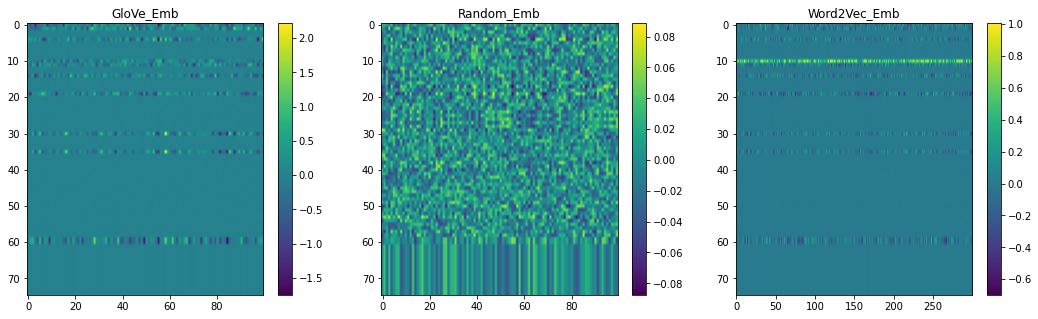

In [ ]:
# 3 Channels
first_layer_activation = activations[3:6]
ln=[]
for layer in model1.layers[3:6]:
    ln.append(layer.name)  
n_l=len(ln)
fig, axs = plt.subplots(nrows=n_l//3, ncols=3,figsize=(18,5))
j=0

for n,i in zip(ln,first_layer_activation):
  ax = plt.subplot(n_l//3, 3,  j+ 1)
  plt.title(n)
  plt.imshow(i[0,:,:],cmap='viridis',aspect='auto')
  plt.colorbar()
  j=j+1
plt.savefig("embbd.png", dpi=600)
plt.show()
 
# 15th channel of the image after first layer of convolution is applied
#plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model1.save("drive/MyDrive/Spam_Models/M3P_fullData.h5",save_format='h5')

In [ ]:
model2 = keras.models.load_model('drive/MyDrive/Spam_Models/M3P_new_banking.h5')

8) VISUALIZATION

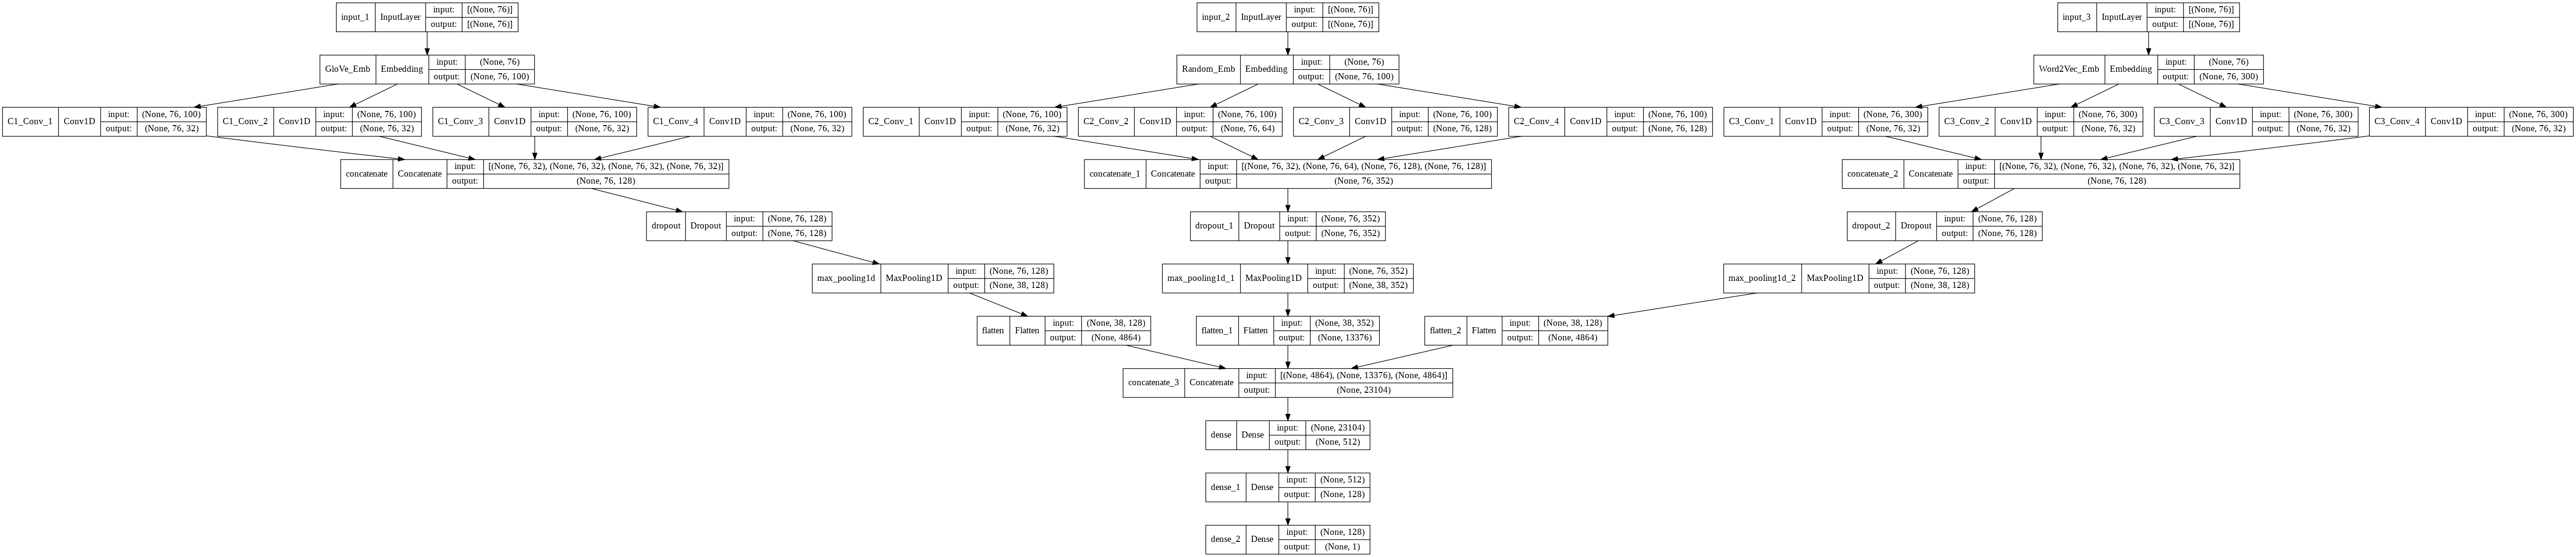

In [ ]:
plot_model(model1, show_shapes=True)

In [ ]:
spam_word_count=defaultdict(int)
ham_word_count=defaultdict(int)

for i,string in enumerate(train_msg):
     for w in string.split():
        if Y_train[i]==1:
          spam_word_count[w]=spam_word_count[w]+1
        else:
          ham_word_count[w]=ham_word_count[w]+1
    
spam_word_count=dict(sorted(spam_word_count.items(),key=lambda x:x[1],reverse=True))
ham_word_count=dict(sorted(ham_word_count.items(),key=lambda x:x[1],reverse=True))

print("Top Spam words are ",spam_word_count)

Top Spam words are  {'free': 521, 'BHK': 458, 'R.': 457, 'atomic': 452, '£': 412, 'constant': 376, 'T': 325, 'people': 282, 'day': 275, 'C': 272, 'gas': 250, 'p': 230, 'upto': 229, 'invest': 228, 'start': 226, 'txt': 218, 'ly': 203, 'Rs': 200, 's': 200, 'com': 184, 'u': 182, 'know': 181, 'today': 176, 'st': 176, 'apply': 168, 'Lac': 166, 'Radius': 164, 'sms': 160, 'Universal': 159, 'lskt': 154, 'R': 152, 'min': 152, 'Roentgen': 149, 'Apply': 149, 'home': 143, 'text': 142, 'cash': 142, 'pm': 134, 'visit': 131, 'click': 129, 'state': 129, 'service': 126, 'c': 122, 'web': 120, 'claim': 119, 'win': 119, 'Gas': 118, 'pay': 115, 'time': 114, 'numbeRs15': 114, 'good': 114, 'book': 111, 'Thane': 108, 'mobile': 104, 'send': 103, 'operate': 102, 'information': 101, 'line': 101, 'live': 98, 'Pension': 96, 'credit': 95, 'world': 94, 'save': 93, 'stop': 92, 'Sms': 92, 'bit': 91, 'Lenskart': 91, 'Book': 89, 'www': 88, 'app': 87, 'plan': 87, 'price': 87, 'family': 86, 'valid': 86, 'rate': 85, 'Free':

In [ ]:
print("Top ham words are ",ham_word_count)

Top ham words are  {'u': 1016, 's': 652, 'technology': 595, 'information': 576, 'gt': 470, 'state': 444, 'lt': 437, 'atomic': 436, 'will': 407, 'not': 390, '1': 364, 't': 344, 'come': 324, 'tree': 314, 'day': 295, 'non': 295, 'pine': 287, 'go': 269, 'm': 269, 'maine': 259, 'good': 245, 'know': 239, 'time': 233, 'love': 214, 'sorry': 211, 'like': 196, 'today': 193, 'ü': 185, 'tell': 185, 'get': 183, 'ok': 180, 'want': 179, 'leave': 179, 'plan': 167, 'single': 164, 'numbeRs53': 163, 'send': 162, 'pls': 160, 'hey': 157, 'need': 155, 'think': 154, 'n': 149, 'work': 145, 'Jio': 141, 'd': 140, 'thank': 136, 'unity': 135, 'Ane': 133, 'Iodin': 133, 'home': 129, 'iodine': 129, 've': 124, 'right': 123, 'yes': 121, 'simply': 120, 'ask': 116, 'tomorrow': 116, 'live': 109, 'Ace': 108, 'wat': 108, 'numbeRs92': 106, 'thing': 104, 'don': 104, 'great': 102, 'place': 100, 'hi': 98, 'hope': 97, 'to': 96, 'miss': 95, 'room': 94, 'attorney': 92, 'way': 92, 'da': 92, 'let': 91, 'e': 91, 'mean': 91, 'say': 9

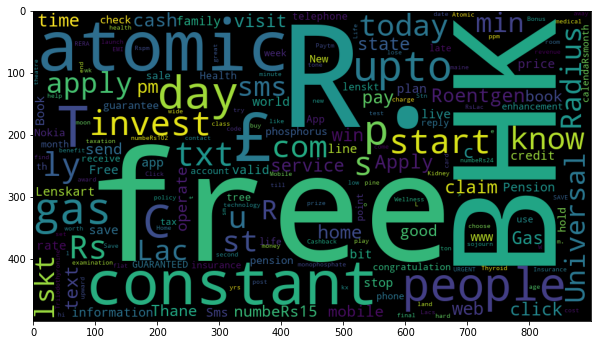

In [ ]:
wordcloud = WordCloud(width = 900, height = 500).generate_from_frequencies(spam_word_count)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud)

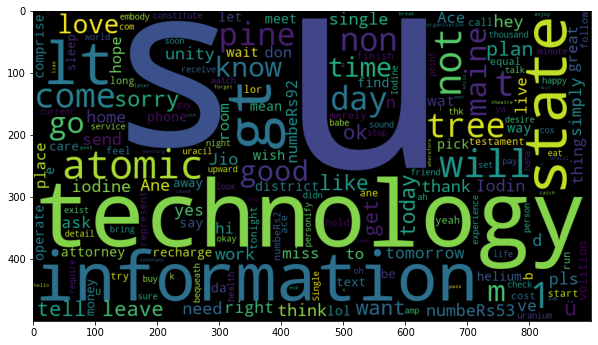

In [ ]:
wordcloud = WordCloud(width = 900, height = 500).generate_from_frequencies(ham_word_count)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud)

Prediction

In [ ]:
bnk=pd.read_csv('ham_transactions_few_spam.csv')
bnk['url']= bnk["message"].str.extract(pattern, expand=False).str.strip()
bnk["message"]= bnk["message"].str.replace(pattern," ")
bnk["message"]= bnk["message"].str.replace(pattern2," ")
bnk["message"]= bnk["message"].str.replace("+","")
bnk['url'].fillna("-",inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


In [ ]:
t=list(bnk["message"])
with open('drive/MyDrive/Spam_Models/tokenizer_latest_banking.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
t= encode_text(tokenizer, t, length+1)
ypred = model2.predict([t,t,t])>0.5
ypred=ypred.astype('int32')
print(classification_report(ypred, bnk['label'],digits=4))


192
              precision    recall  f1-score   support

           0     0.2328    0.9362    0.3729        47
           1     0.0000    0.0000    0.0000       145

    accuracy                         0.2292       192
   macro avg     0.1164    0.4681    0.1864       192
weighted avg     0.0570    0.2292    0.0913       192



In [ ]:
ypred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
    

In [ ]:
t=input()
t= encode_text(tokenizer, [t], length)
ypred2 = model1.predict([t,t,t])>0.5
ypred2=ypred2.astype('int32')
ypred2

Update! INR 20,000.00 deposited in HDFC Bank A/c XX0118 on 24-JAN-22 for UPI-Jash Chirag Shah-stylxbeautyprofessional09@oksbi-IDFB0040101-202420959164-UPI.Avl bal INR 43,729.59. Cheque deposits in A/C are subject to clearing
1


array([[0]], dtype=int32)

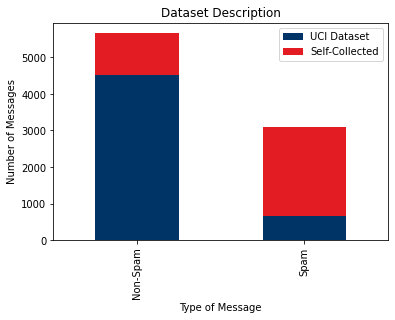

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame({'UCI Dataset': [4516,653],
                   'Self-Collected': [1153,2429]},
                  index=['Non-Spam','Spam'])
df.plot(kind='bar', stacked=True, color=['#003366', '#E31B23'])
  
# labels for x & y axis
plt.ylabel('Number of Messages')
plt.xlabel('Type of Message')
  
# title of plot
plt.title('Dataset Description')
plt.savefig("data.png")

In [ ]:
len(train_msg)

11298

In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [ ]:
for n,i in enumerate(t1[0]):
  print(n,"   ", i," ----  ",reverse_word_map[i])
1,  4, 11, 13, 14, 16, 29, 30, 34, 56, 57

0     180  ----   buy
1     23  ----   1
2     1623  ----   2
3     12683  ----   3
4     13  ----   bhk
5     708  ----   north
6     992  ----   garden
7     1281  ----   city
8     1038  ----   mira
9     7735  ----   rdclose
10     142  ----   to
11     44  ----   new
12     390  ----   metro
13     379  ----   stn
14     5  ----   free
15     5572  ----   pickup
16     364  ----   drop
17     2621  ----   for
18     372  ----   site
19     117  ----   visit
20     1650  ----   amenity
21     532  ----   club
22     2168  ----   library
23     4863  ----   swimming
24     1428  ----   pool
25     3969  ----   kids
26     1428  ----   pool
27     3987  ----   ladies
28     1428  ----   pool
29     453  ----   meeting
30     97  ----   room
31     1676  ----   table
32     4438  ----   tennis
33     287  ----   game
34     97  ----   room
35     5442  ----   steam
36     7741  ----   sauna
37     2591  ----   spa
38     1244  ----   gymnasium
39     14042  ----   rooms
40     3837  -

KeyError: ignored

In [ ]:
activations[4][1]

array([[-0.05433454, -0.0402456 , -0.04578167, ...,  0.0013653 ,
         0.03032903, -0.03554875],
       [ 0.02026485,  0.02774278, -0.05258896, ..., -0.02917752,
         0.02929963,  0.04172981],
       [-0.02074769,  0.01159826,  0.03947809, ..., -0.02692615,
        -0.02934924,  0.00353928],
       ...,
       [-0.00216683,  0.01437178, -0.02590578, ..., -0.04325171,
        -0.00274888,  0.03446228],
       [-0.00216683,  0.01437178, -0.02590578, ..., -0.04325171,
        -0.00274888,  0.03446228],
       [-0.00216683,  0.01437178, -0.02590578, ..., -0.04325171,
        -0.00274888,  0.03446228]], dtype=float32)

In [ ]:
np.where(activations[3][1].any(axis=1))[0]

array([ 1,  4, 11, 13, 14, 16, 29, 30, 34, 56, 57])

In [ ]:
1,  4, 11, 13, 14, 16, 29, 30, 34, 56, 57
1,  4, 11, 13, 14, 16, 29, 30, 34, 56, 57